# TP 09: Problème d'obstacle

$$
\newcommand{\sca}[2]{\langle #1\mid #2 \rangle}
\newcommand{\nr}[1]{\left\|#1\right\|}
\newcommand{\LL}{\mathrm{L}} 
\newcommand{\Rsp}{\mathbb{R}}
\newcommand{\Psp}{\mathbb{P}}
\newcommand{\Class}{\mathcal{C}}
$$
Soit $\Omega$ un ouvert de $\Rsp^2$ et $\Psi\in H^1_0(\Omega) \cap \Class^\infty(\Omega)$. On s'intéresse à la résolution du problème d'obstacle:
$$
\min_{v\in C} \int_\Omega \nr{\nabla v}^2
$$
où $C = \{ u\in H^1_0(\Omega) \mid u \geq \Psi\}$.
On discrétise ce problème par la méthode des éléments finis en 2D. On part d'une triangulation $T_h$ de l'ouvert $\Omega$, et on note:
* $V_h$ l'espace des éléments finis $\Psp_1$ sur $T_h$, de sorte que $V_h\subseteq V := H^1(\Omega)$;
* $N_h :=\dim(V_h)$;
* $x_1,\dots,x_{N_h}$ les sommets de la triangulation et $\psi_1,\dots,\psi_{N_h}$ les fonctions chapeau correspondantes. On note $J_h$ l'ensemble des indices des sommets du bord.
* $V_{0h} = \{ v\in V_h\mid \forall k\in J_h, v(x_k) = 0 \}$
* $C_h = \{ v\in V_{0h}\mid \forall 1\leq i\leq N_h,~~ v(x_i) \geq \Psi(x_i) \}$

Le problème discret est alors donné par 
$$
\min_{v\in C_h} \int_\Omega \nr{\nabla v}^2.
$$

**Q1.** On note $W = (v_1,\dots,v_{N_h}) \in \Rsp^{N_h}$ les valeurs d'une fonction $v\in V_h$ sur les sommets $x_1,\dots,x_{N_h}$ (i.e. $v = \sum_{1\leq i\leq N_h} v_i \phi_i$ où $\phi_i$ est la base de $V_h$ formée des fonctions chapeau). Montrer que le problème peut être mis sous la forme

$$ \min_{W\in D_h} \sca{W}{A W} $$
$$D_h = \{ W\in \Rsp^{N_h} \mid \forall 1\leq i\leq N_h, W_i \geq \Psi(x_i) \hbox{ et } \forall k\in J_h,~ W_k = 0\},$$

où $A_{ij} = \int_\Omega \sca{\nabla \phi_i}{\nabla \phi_j}$.


**Q2.** Soit $W\in \Rsp^{N_h}$. Montrer que la projection orthogonale de $W$ sur $D_h$ est donnée par

$$ \Pi_{D_h}(W) = \begin{cases} \max(W_i,\Psi(x_i)) & \hbox{ si } i\not\in J_h \\
0 & \hbox{ sinon } 
\end{cases}. $$

**Q3.** Écrire explicitement l'algorithme de gradient projeté (à pas constant) dans le cas où $J(W) = W^T A W$ et $K =  D_h$. Expliciter la condition nécessaire sur le pas de descente en fonction des valeurs propres de la matrice $A$.

**Q4.** Implémenter cet algorithme dans le cas du carré  $\Omega = (-1,1)^2$, en utilisant
$ \Psi(x,y) = \kappa(2x^2+2y^2) $
où $\kappa(t) = \exp(-1/(1-t^2))$ si $t<1$ et $0$ sinon.

Utiliser les fonction fournies pour trianguler le disque et calculer la matrice de rigidité. On pourra utiliser `np.where` pour construire la liste $J$ des indices des poins du bord. On pourra visualiser le graphe d'une fonction en 3D en utilisant la fonction


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import numpy as np
import matplotlib.tri as tri


from mpl_toolkits.mplot3d import Axes3D

def triangulation_carre(n):
    x,y = np.meshgrid(np.linspace(-1.,1.,n),
                      np.linspace(-1.,1.,n))
    x = x.reshape(n*n,1)
    y = y.reshape(n*n,1)
    X = np.hstack((x,y))
    T = tri.Triangulation(x.flatten(), y.flatten()).triangles
    return X,T

# afficher la triangulation dont les sommets sont [X[:,0],X[:,1],Z] et les triangles T
def afficher_triangulation_3d(X,T,Z):
    fig = plt.figure(figsize=plt.figaspect(0.5))
    ax = fig.add_subplot(1, 2, 1, projection='3d',)
    ax.plot_trisurf(X[:,0],X[:,1],Z,triangles=T, cmap=plt.cm.Spectral, shade=True)
    plt.show()

def M_elem(S1,S2,S3):
    x1 = S1[0]
    y1 = S1[1]
    x2 = S2[0] 
    y2 = S2[1]
    x3 = S3[0]
    y3 = S3[1]
    D = ((x2-x1)*(y3-y1) - (y2-y1)*(x3-x1))
    M=(1.*np.abs(D)/24)*np.ones([3,3])
    M[range(3),range(3)]=1.*np.abs(D)/12
    return M

def K_elem(S1,S2,S3):
    x1 = S1[0]
    y1 = S1[1]
    x2 = S2[0] 
    y2 = S2[1]
    x3 = S3[0]
    y3 = S3[1]
    norm = np.zeros([3, 2])
    norm[0, :] = np.array([y2-y3, x3-x2])
    norm[1, :] = np.array([y3-y1, x1-x3])
    norm[2, :] = np.array([y1-y2, x2-x1])
    D = ((x2-x1)*(y3-y1) - (y2-y1)*(x3-x1))
    K = np.zeros([3,3])
    for i in range(3):
        for j in range(3):
            K[i,j] = np.dot(norm[i,:],norm[j,:])
    return (1./(2*abs(D)))*K

def masse_et_rigidite(X,T):
    NSom = X.shape[0]
    NTri = T.shape[0]
    K = np.zeros([NSom,NSom])
    M = np.zeros([NSom,NSom])
    for N in range(0,NTri):
        S1=X[T[N,0],:]
        S2=X[T[N,1],:]
        S3=X[T[N,2],:]
        Kel=K_elem(S1, S2, S3)
        Mel=M_elem(S1, S2, S3)
        for i in range(0,3): 
            I = T[N,i]
            for j in range(0,3): 
                J = T[N,j]
                M[I,J] = M[I,J] + Mel[i,j]
                K[I,J] = K[I,J] + Kel[i,j]
    return M,K

lambda_n = 7.97734


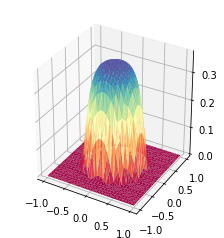

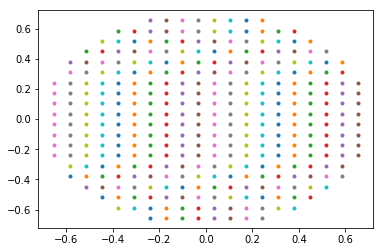

0.0
6.727523375463608


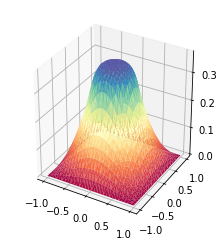

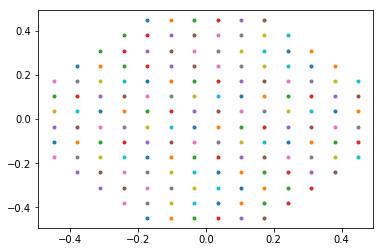

0.0006597926148513406
0.0


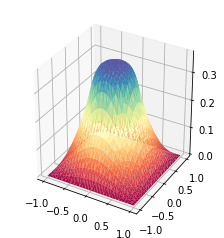

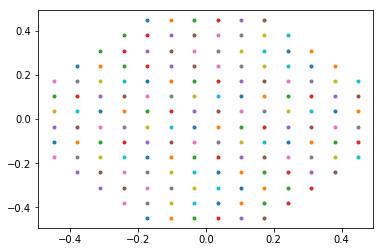

2.6185565276139796e-06
0.0


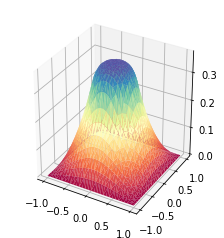

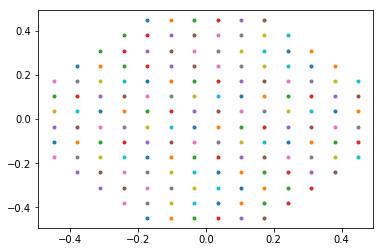

1.0484566225621663e-08
0.0


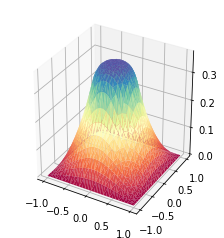

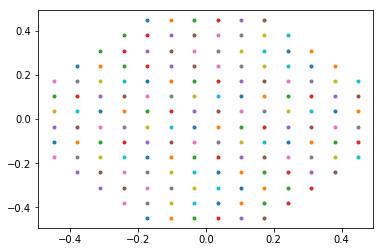

4.285751688367701e-11
0.0


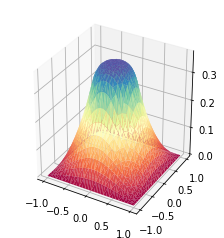

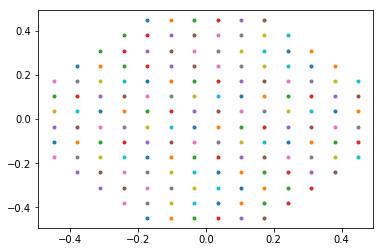

1.8387632246275728e-13
0.0


In [4]:
X,T = triangulation_carre(30)
M,K = masse_et_rigidite(X,T)
A = K.copy()
J = np.where(np.logical_or(np.abs(X[:,0]) >= 1 - 1e-10, np.abs(X[:,1]) >= 1-1e-10))
N = len(X)

# definition de Psi
def kappa(t):
    r = np.zeros_like(t)
    I = np.abs(t) < 1
    r[I] = np.exp(-1/(1-t[I]**2))
    return r
    
#plt.figure()
Psi = kappa(2*(X[:,0]**2 + X[:,1]**2))
#plt.tripcolor(X[:,0],X[:,1],T,Psi,shading='gouraud')
#plt.axis('equal')

# calcul des valeurs propres
vp = np.linalg.eigh(A)[0]
print('lambda_n = %g'%max(vp))


tau = 2/max(vp)
v = np.zeros(N)
for i in range(1001):
    v = v - tau * np.dot(A,v)
    v = np.maximum(v, Psi)
    v[J] = 0
    if i%200==0:
        afficher_triangulation_3d(X,T,v)
        Iactive = np.where(np.logical_and(v <= Psi, v > 0))
        Iinactive = np.where(v > Psi)
        plt.plot(X[Iactive,0],X[Iactive,1],'.')
        plt.show()
        print(np.linalg.norm(np.dot(A, v)[Iinactive]))
        print(np.sum(np.maximum(-np.dot(A, v)[Iactive], 0.0)))  


**Q7.** Démontrer que $U$ est optimal pour le problème discret ($\min_{W\in K_h} W^T A W$) si et seulement si il vérifie les conditions suivantes:

$$ \begin{cases}
U_i = 0 & \hbox{ si } i \in J_h \hbox{ (bord) } \\
- A U_i \geq 0 & \hbox{ si } U_i = \Psi_i \\
- A U_i = 0 & \hbox{ si } U_i > \Psi_i 
\end{cases} $$

En déduire un critère permettant de vérifier la convergence de l'algorithme du gradient projeté, et vérifier la convergence de l'algorithme sur l'exemple.